In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
import tensorflow as tf

import glob, os, random

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Note: using Google CoLab")

Mounted at /content/drive
Note: using Google CoLab


In [3]:
txt_path = '/content/drive/My Drive/garbage_txt'
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))


In [4]:
len(img_list)

2388

In [5]:
res = tf.keras.models.load_model('/content/drive/My Drive/kagglemodel/resnetOWN.model')

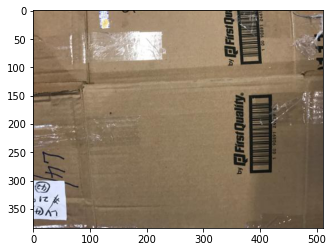

In [8]:
plt.imshow(load_img(img_list[0]))

In [9]:
img_list[0]

'/content/drive/My Drive/Garbage classification/cardboard/cardboard108.jpg'

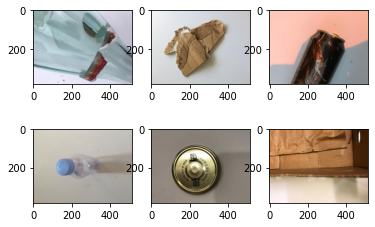

In [10]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [11]:
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2150 images belonging to 5 classes.
Found 238 images belonging to 5 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}


In [ ]:
path = '/content/drive/My Drive/kagglemodel/part23conv.hdf5'
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(path , monitor='val_acc', save_best_only=True, mode='max', verbose = 1)
callback_list = [checkpoint1]

In [ ]:
model.load_weights(path)

In [ ]:
model.save('/content/drive/My Drive/kagglemodel/kggale_part2.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/kagglemodel/kaggle_80val.model/assets


In [12]:
import pandas as pd
import re
from tensorflow.keras.applications import ResNet50


In [13]:
def list_dataset():
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
# Add class name prefix to each path based on class name include in filename

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal'}
    return label_map[id]
    

    
train_file = os.path.join(txt_path,'one-indexed-files-notrash_train.txt')
val_file   = os.path.join(txt_path,'one-indexed-files-notrash_val.txt')
test_file  = os.path.join(txt_path,'one-indexed-files-notrash_test')

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')




In [14]:
df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

In [15]:
train_file

'/content/drive/My Drive/garbage_txt/one-indexed-files-notrash_train.txt'

In [16]:
df_valid

,rel_path,label
0,cardboard/cardboard114.jpg,cardboard
1,plastic/plastic204.jpg,plastic
2,glass/glass123.jpg,glass
3,glass/glass152.jpg,glass
4,glass/glass398.jpg,glass
...,...,...
306,metal/metal58.jpg,metal
307,cardboard/cardboard149.jpg,cardboard
308,plastic/plastic5.jpg,plastic
309,glass/glass23.jpg,glass


In [17]:
df_test  

,rel_path,label
0,cardboard/cardboard114.jpg,cardboard
1,plastic/plastic204.jpg,plastic
2,glass/glass123.jpg,glass
3,glass/glass152.jpg,glass
4,glass/glass398.jpg,glass
...,...,...
306,metal/metal58.jpg,metal
307,cardboard/cardboard149.jpg,cardboard
308,plastic/plastic5.jpg,plastic
309,glass/glass23.jpg,glass


In [19]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=5)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])



94773248/94765736 [==============================] - 1s 0us/step


In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
68/68 [==============================] - 582s 8s/step - loss: 1.4636 - categorical_accuracy: 0.5919 - val_loss: 0.5016 - val_categorical_accuracy: 0.8193
Epoch 2/30
68/68 [==============================] - 47s 690ms/step - loss: 0.3551 - categorical_accuracy: 0.8745 - val_loss: 0.4833 - val_categorical_accuracy: 0.8445
Epoch 3/30
68/68 [==============================] - 47s 693ms/step - loss: 0.2646 - categorical_accuracy: 0.9025 - val_loss: 0.4235 - val_categorical_accuracy: 0.8445
Epoch 4/30
68/68 [==============================] - 47s 692ms/step - loss: 0.2128 - categorical_accuracy: 0.9212 - val_loss: 0.3472 - val_categorical_accuracy: 0.8782
Epoch 5/30
68/68 [==============================] - 47s 691ms/step - loss: 0.1498 - categorical_accuracy: 0.9514 - val_loss: 0.3387 - val_categorical_accuracy: 0.8697
Epoch 6/30
68/68 [==============================] - 47s 695ms/step - loss: 0.1529 - categorical_accuracy: 0.9484 - val_loss: 0.4269 - val_categorical_accuracy: 0.8487


In [22]:
net.save('/content/drive/My Drive/kagglemodel/resnetMODI.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/kagglemodel/resnetMODI.model/assets
